## Stimulus generation for context-detection task in silico

In [1]:
import numpy as np
from rgc_natstim_model.utils.data_handling import unPickle,makePickle
from rgc_natstim_model.utils.nm_vis import img_real2view,get_rectangle_corners, downSample 
import cv2
import matplotlib.pyplot as plt

In [2]:
data_path = '/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/data/simulation/stimulus_generation/'

### 500 nature movie frames from Qiu et al 2021's recording
#### The horizon in each frame was pointautomatically labelled with 15 points by DeepLabCut

In [3]:
selected_movie_frames = np.load(data_path+'selected_movie_frames.npy') 
selected_horizon_prediction = np.load(data_path+'selected_horizon_prediction.npy')

In [4]:
print(selected_movie_frames.shape) # numFrame Height Width ColorChan
print(selected_horizon_prediction.shape) # numFrame numPoints (x_coor,y_coor,probability)

(500, 437, 437, 3)
(500, 15, 3)


#### an example

Text(0.5, 1.0, 'An example frame with predicted horizon points')

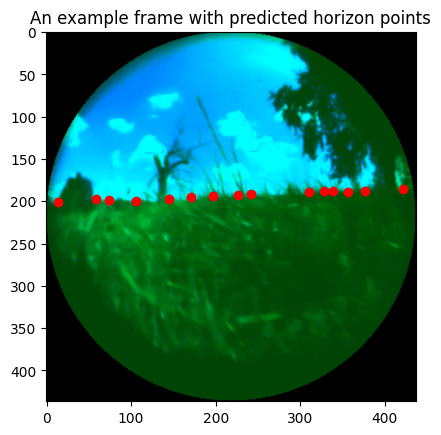

In [5]:
frame_idx = 0
plt.imshow(img_real2view(selected_movie_frames[frame_idx][...,::-1]))
for pp in range(15):
    xx,yy = selected_horizon_prediction[frame_idx,pp,:2]
    plt.scatter(xx,yy,color='r')
plt.title("An example frame with predicted horizon points")

### Define the cropping trajectory

#### Define the four corners of the sampling trajectory

Within one same movie frame, the direction of sampling is defined differently in clockwise and counter-clockwise. But the order of transition type remains the same. 


Clockwise: up_left->up_right->down_right->down_left, 's-s'->'s-g'->'g-g'->'g->s';


Counter-clockwise: up_right->up_left->down_left->down_right, 's-s'->'s-g'->'g-g'->'g->s'

In [6]:
up_left = (100,100)
up_right = (320,100)
down_left = (100,320)
down_right = (320,320)

#### Select and prepare one movie frame to visualize the sampling trajectory

In [7]:
horizon_xys = selected_horizon_prediction[frame_idx,:,:2]
trace = np.copy(selected_movie_frames[frame_idx])
R_trace = np.copy(selected_movie_frames[frame_idx])

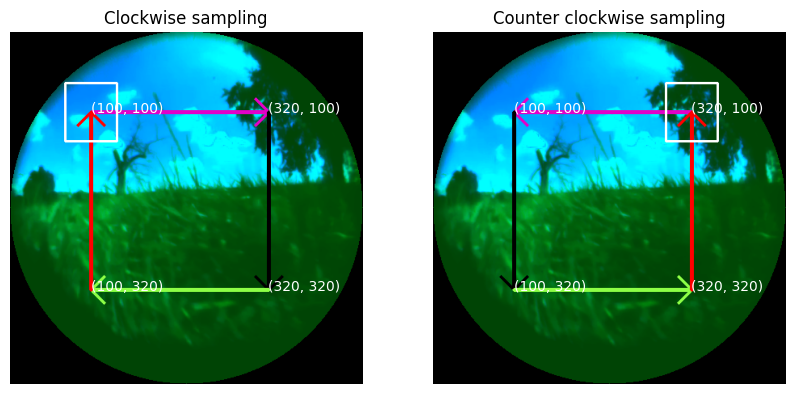

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,5),facecolor='white')

## visualize the clock-wise sampling
cv2.arrowedLine(trace,up_left,up_right,color = (200,0,200),thickness = 3)
cv2.arrowedLine(trace,up_right,down_right,color = (0,0,0),thickness = 3)
cv2.arrowedLine(trace,down_right,down_left,color = (70,255,70),thickness = 3)
cv2.arrowedLine(trace,down_left,up_left,color = (0,0,255),thickness = 3)
cv2.rectangle(trace,(100-32,100-36),(100+32,100+36),color = (255,255,255),thickness =2)

ax[0].imshow(img_real2view(trace[...,::-1]))
ax[0].set_title('Clockwise sampling')
ax[0].axis('off')

## visualize the counter-clock-wise sampling
cv2.arrowedLine(R_trace,up_right,up_left,color = (200,0,200),thickness = 3)
cv2.arrowedLine(R_trace,up_left,down_left,color = (0,0,0),thickness = 3)
cv2.arrowedLine(R_trace,down_left,down_right,color = (70,255,70),thickness = 3)
cv2.arrowedLine(R_trace,down_right,up_right,color = (0,0,255),thickness = 3)
cv2.rectangle(R_trace,(320-32,100-36),(320+32,100+36),color = (255,255,255),thickness = 2)
ax[1].imshow(img_real2view(R_trace[...,::-1]))
ax[1].set_title('Counter clockwise sampling')
ax[1].axis('off')

## annotate the corners of the cropping trajectory
for xx in range(2):
    for coor in [up_left,up_right,down_left,down_right]:
        ax[xx].annotate('{}'.format(coor),coor,color = 'white')

### Take 72x64 crops with different speeds/stepsizes 

In [9]:
speeds = [4,12,20,28] ## unit: pxl, anologous to the stepsize of cropping =

#### a quick demo with speed = 4 

In [10]:
speeds=[4]

In [11]:
## load the pre-defined positions for cropping
speeds_pos = unPickle(data_path+'speed4122028_posDict.pkl') # dict
R_speed_pos = unPickle(data_path+'R_speed4122028_posDict.pkl') # dict

Take a quick look what the dictionary is like

In [12]:
print(speeds_pos.keys()) ## speed is used as the key

dict_keys([4, 12, 20, 28])


In [13]:
print(len(speeds_pos[4])) ## for speed=4, 224 crops will be taken, this parameter varies across speeds
print(speeds_pos[4][:20]) ## inspect the coordinates for a few cropping positions

224
[(100, 100), (104, 100), (108, 100), (112, 100), (116, 100), (120, 100), (124, 100), (128, 100), (132, 100), (136, 100), (140, 100), (144, 100), (148, 100), (152, 100), (156, 100), (160, 100), (164, 100), (168, 100), (172, 100), (176, 100)]


#### Start cropping

In [14]:
print_iter = 50

In [30]:
for speed in speeds:
    ## extract all cropping positions for clockwise & counter-clockwise cropping
    pos = speeds_pos[speed]
    r_pos = R_speed_pos[speed]
    
    s_ds_output = np.zeros((len(selected_movie_frames),2,len(pos),18,16)) # numFrame, colorCh, numCrop,18 16
    R_ds_output = np.zeros((len(selected_movie_frames),2,len(r_pos),18,16)) # numFrame, colorCh, numCrop,18 16
    
    for ff, frame in enumerate(selected_movie_frames):
        if ff%print_iter ==0:
            print('For frame no.{}'.format(ff))
        ## for each selected frame (/500)
        ## clockwise cropping
        output = np.zeros((len(pos),72,64,3))
        ds_output = np.zeros((len(output),2,18,16))
        
        for pp in range(len(pos)):
            ## for each crop's center coordinate
            crop_points = get_rectangle_corners(pos[pp])
            h_top_left,v_top_left = crop_points[0]
            ## take a crop at each position (altogether 224 positions for speed4)
            crop = np.copy(frame)[v_top_left:v_top_left+72,h_top_left:h_top_left+64,:]
            output[pp] = np.copy(crop)
            
            ## downsample a 72x64 crop to 18x16
            ds_output[pp,0] = downSample(np.copy(crop)[:,:,1])
            ds_output[pp,1] = downSample(np.copy(crop)[:,:,0])
            if pp == len(pos)-1 and ff%print_iter==0:
                print('    done clockwise')
        ds_output = ds_output.transpose((1,0,2,3)).reshape((1,2,max(ds_output.shape),18,16))
        s_ds_output[ff] = np.copy(ds_output)
        
        ## counter-clockwise
        output = np.zeros((len(r_pos),72,64,3))
        ds_output = np.zeros((len(r_pos),2,18,16))
        for pp in range(len(r_pos)):
            ## for each crop's center coordinate
            crop_points = get_rectangle_corners(r_pos[pp])
            h_top_left,v_top_left = crop_points[0]
            
            ## take a crop at each position /224 for speed4
            crop = np.copy(frame)[v_top_left:v_top_left+72,h_top_left:h_top_left+64,:]
            output[pp] = np.copy(crop)
            ds_output[pp,0] = downSample(np.copy(crop)[:,:,1])
            ds_output[pp,1] = downSample(np.copy(crop)[:,:,0])
            if pp == len(r_pos)-1 and ff%print_iter==0:
                print("    counter clockwise done")
        ds_output = ds_output.transpose((1,0,2,3)).reshape((1,2,max(ds_output.shape),18,16))
        R_ds_output[ff] = np.copy(ds_output)
        
    # np.save(data_path+"sti500_s{}_18x16.npy".format(speed),s_ds_output)
    # np.save(data_path+"R_sti500_s{}_18x16.npy".format(speed),R_ds_output)

For frame no.0
    done clockwise
    counter clockwise done
For frame no.50
    done clockwise
    counter clockwise done
For frame no.100
    done clockwise
    counter clockwise done
For frame no.150
    done clockwise
    counter clockwise done
For frame no.200
    done clockwise
    counter clockwise done
For frame no.250
    done clockwise
    counter clockwise done
For frame no.300
    done clockwise
    counter clockwise done
For frame no.350
    done clockwise
    counter clockwise done
For frame no.400
    done clockwise
    counter clockwise done
For frame no.450
    done clockwise
    counter clockwise done
For frame no.0
    done clockwise
    counter clockwise done
For frame no.50
    done clockwise
    counter clockwise done
For frame no.100
    done clockwise
    counter clockwise done
For frame no.150
    done clockwise
    counter clockwise done
For frame no.200
    done clockwise
    counter clockwise done
For frame no.250
    done clockwise
    counter clockwise don

To quickly access the pre-generated .npy

In [70]:
# speed = 4

# ds_output = np.load(data_path+"sti500_s{}_18x16.npy".format(speed))
# R_ds_output = np.load(data_path+"R_sti500_s{}_18x16.npy".format(speed))

In [72]:
print(ds_output.shape)
print(R_ds_output.shape)

(500, 2, 224, 18, 16)
(500, 2, 224, 18, 16)


#### Reshape the 18x16 crops for the next step (Gray-padding)

In [82]:
for speed in speeds:
    print(speed)
    snippet_len = len(speeds_pos[speed])//4 # numCrops per transition type

    clockwise1816= np.load(data_path+'sti500_s{}_18x16.npy'.format(speed))
    R_clockwise1816 = np.load(data_path+'R_sti500_s{}_18x16.npy'.format(speed))
    output = np.concatenate((clockwise1816,R_clockwise1816),axis=0)

    ## make the datashape suitable for gray-padding in the next step
    output = output.reshape((1000,2,4,snippet_len,18,16)).transpose((0,2,1,3,4,5))
    input_for120f = output.reshape((4000,2,snippet_len,18,16))
    print(output.shape) # numFramex2 numTransitionType colorCh numCropPerTransition Height Width
    # np.save(data_path+'sti1000_{}f_s{}_18x16.npy'.format(snippet_len,speed),input_for120f)

4
(1000, 4, 2, 56, 18, 16)


##### A quick demo one transition snippet

In [83]:
input_for120f.shape

(4000, 2, 56, 18, 16)

In [87]:
movie_frame = 0 # 0~999
transition_type = 0 # 0->s-s, 1->s-g, 2->g-g, 3->g->s

Text(0.5, 0.98, 'One transition snippet')

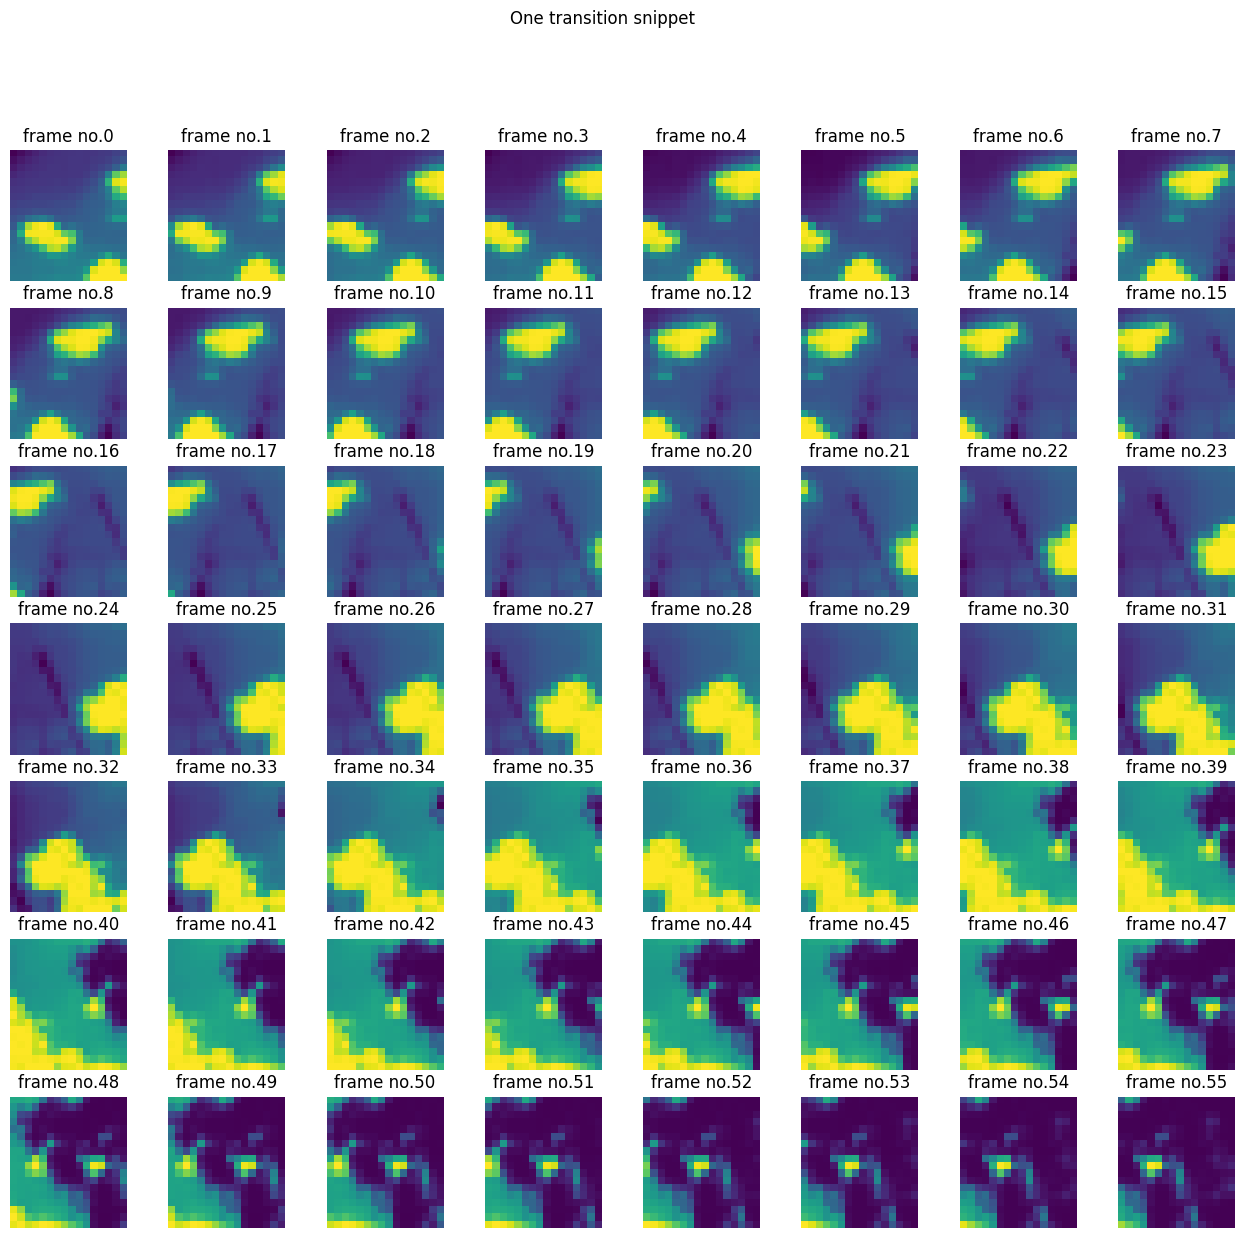

In [90]:
fig,ax= plt.subplots(7,8,figsize=(16,14))
ax=ax.flatten()
for ff in range(56):
    ax[ff].imshow(input_for120f[movie_frame*4+transition_type,0,ff])
    ax[ff].set_title('frame no.{}'.format(ff))
    ax[ff].axis('off')
fig.suptitle('One transition snippet')

### Pad each transition snippet regardless of the length into 120-frame length

In [91]:
## predefine parameters for padding, due to different speeds, the required number of gray padding varies.
speed2snippetLen = unPickle(data_path+'speed2snippetLen.pkl')
speed2embbedingidx= unPickle(data_path+'speed2embbedingidx.pkl')

In [93]:
for speed in speeds:
    origin_sti = np.load(data_path+'sti1000_{}f_s{}_18x16.npy'.format(speed2snippetLen[speed],speed))
    
    len_tt = speed2snippetLen[speed]
    output = np.zeros((4*1000,2,120,18,16))
    indx1 = speed2embbedingidx[speed][0]
    indx2 = speed2embbedingidx[speed][1]
    
    # print(origin_sti.shape)
    output[:,:,:30,:,:]=128
    output[:,:,-30:,:,:]=128
    for snip in range(4000):
        orig = origin_sti[snip] # 2,56,18,16
        # print(orig.shape)
        for beg in range(30,indx1+30):
            # print(beg)
            output[snip,:,beg] = orig[:,0]
        for end in range(1,indx2):
            # print(-1*end-30+120)
            output[snip,:,-1*end-30] = orig[:,-1]
        output[snip,:,indx1+30:indx1+len_tt+30] = orig
    output = output.reshape((1000,4,2,120,18,16))
    print(output.shape)
    # np.save(data_path+'sti1000_120f_s{}_18x16.npy'.format(speed),output)

(1000, 4, 2, 120, 18, 16)


#### A quick demo of one 120f-snippet

In [94]:
## define a numerical code for transition types
tt_dict = {
    0: 's-s', 
    1: 's-g', 
    2:'g-g', 
    3:'g-s'
}

Text(0.5, 1.0, 'Frame 273, transition s-s')

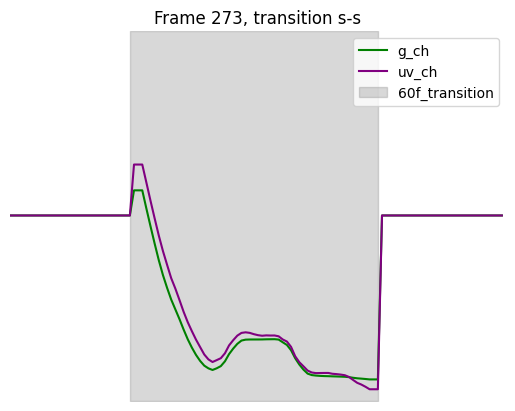

In [104]:
## take a random frame and a random transition type
frame_idx = np.random.randint(1000)
tt_idx=np.random.randint(4) # 0: s-s, 1: s-g, 2:g-g, 3:g-s
## using color channels' changes depict the transition
plt.plot(np.mean(output[frame_idx,tt_idx,0],axis=(-1,-2)),color='g',label='g_ch')
plt.plot(np.mean(output[frame_idx,tt_idx,1],axis=(-1,-2)),color='purple',label='uv_ch')
plt.fill_between((29,89),255,label='60f_transition',color='gray',alpha=0.3)
plt.axis('off')
plt.xlim((0,120))
plt.ylim((0,255))
plt.legend()
plt.title('Frame {}, transition {}'.format(frame_idx,tt_dict[tt_idx]))